Run this notebook in Google Colab.
Parts of the code use GPU so go to Runtime -> Change Runtime type - > GPU. 
# Initialize:
This code will prompt you to give access to your google drive, where all the files should be stored. All the file paths should start with "/content/drive/My Drive"

In [2]:
import scipy as sp
import scipy.misc
import imageio
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
!nvidia-smi
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import sys
from scipy.special import expit

from PIL import Image
from IPython.display import display
import random
import os
import cv2
from scipy.optimize import fmin, fmin_tnc
import math
from skimage.filters import threshold_minimum, median
from skimage.morphology import disk
from random import  uniform
from os import listdir
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from IPython.display import clear_output
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
      
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
      
class AugmentedDataset(Dataset):
    def __init__(self, X, transform_X=transforms.ToTensor()):
        self.X = X
        self.transform_X = transform_X
    
    def __getitem__(self, index):
        x = self.X[index]
        x = self.transform_X(x)
        return x

    def __len__(self):
        return len(self.X)
   
def matchshape(confocal,maldi):
    # we assume here confocal has a higher resolution than maldi
    # we reduce the resolution of outlines so the alignment works faster
    h1, w1 = confocal.shape
    h2, w2 = maldi.shape
    common_denominator = h1/512
    maldi = cv2.resize(maldi, dsize=(int(w2*h1/(h2*common_denominator)),int(h1/common_denominator)), interpolation=cv2.INTER_CUBIC)
    confocal = cv2.resize(confocal, dsize=(int(w1/common_denominator),int(h1/common_denominator)), interpolation=cv2.INTER_CUBIC)
    maldi_denominator = h1/h2
    h1, w1 = confocal.shape
    h2, w2 = maldi.shape
    output1 = np.zeros((max(h1,h2),max(w1,w2)))
    output2 = np.zeros((max(h1, h2), max(w1, w2)))
    for i in range(len(output1)):
        try:
            output1[i][:len(confocal[i])] = confocal[i]
        except:
            pass
        try:
            output2[i][:len(maldi[i])] = maldi[i]
        except:
            pass
    return output1.astype(np.uint8),output2.astype(np.uint8), maldi_denominator, common_denominator

def transform_image(X,theta,shiftX,shiftY,scale): # error - negative scale
    (height, width) = X.shape[:2]
    M = cv2.getRotationMatrix2D((width/2,height/2), np.degrees(theta), 1)
    Y = cv2.warpAffine(X, M, (width,height))
    Y = cv2.resize(Y, dsize=(int(width*scale),int(height*scale)), interpolation=cv2.INTER_CUBIC)
    moveX, moveY = width*(scale-1)/2,height*(scale-1)/2
    M = np.float32([[1, 0, shiftX-moveX], [0, 1, shiftY-moveY]])
    res = cv2.warpAffine(Y, M, (int(width*scale),int(height*scale)))
    res = cv2.warpAffine(Y, M, (width,height))
    return res

def error_fun2(p,X,Y):
    """cost function to minimize """
    if p[3] < 0.01: return X.shape[0]**2
    transformed_Y = transform_image(Y,p[0],p[1],p[2],p[3])
    out = np.abs(np.subtract(transformed_Y,X))
    return np.sum(out)

 
def cut_background(image):
  shape = image.shape
  top,bottom,left,right = 0,shape[0],0,shape[1]
  for i in range(shape[0]):
    s = np.sum(image[i,:])
    if s >= 1:
      bottom = i
      if top == 0: top = i
  for i in range(shape[1]):
    s = np.sum(image[:,i])
    if s >= 1:
      right = i
      if left == 0: left = i   
  return image[top:bottom,left:right],[top,bottom,left,right]

def pad_zeros(image, scale, gap = 0):
  h, w = image.shape[:2]
  vertical_zeros = np.zeros((h,int(w*(scale-1)/2)))
  if gap == 0:
    image = np.concatenate((vertical_zeros,image,vertical_zeros),axis = 1)
  else:
    image = np.concatenate((vertical_zeros,image,np.zeros((h,int(w*(scale-1)/2)+gap))),axis = 1)
  horizontal_zeros = np.zeros((int(h*(scale-1)/2),image.shape[1]))
  image = np.concatenate((horizontal_zeros,image,horizontal_zeros),axis = 0)

  return image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tue Oct  8 15:47:16 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+--------------------------------------

Run this next cell to get the confocal image oulines for aligning. "tensor.pt" file is provided in the same github folder with this notebook.

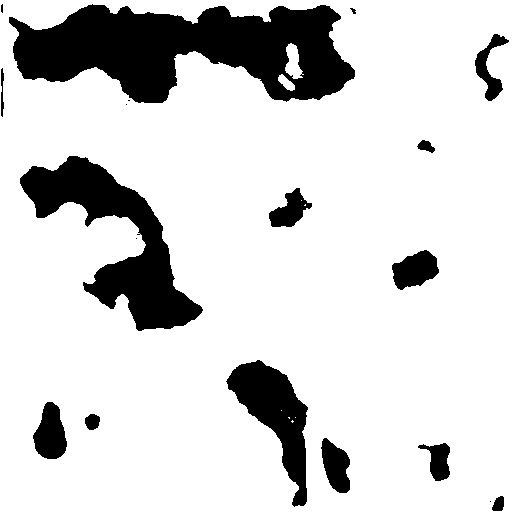

In [33]:
# the confocal should be the image of Hoecst nuclei staining exported as "Item" from Volocity or a similar software
confocal_filename = '/content/drive/My Drive/confocal for segmentation/confocal/DAPI.tif'
model_filename = '/content/drive/My Drive/confocal for segmentation/tensor.pt'
net = UNet(n_channels=3, n_classes=1).cuda()
net.load_state_dict(torch.load(model_filename))
confocal = Image.open(confocal_filename)
w, h = confocal.size
confocal = np.array(confocal)
m = 255.0/np.max(confocal)
z = np.zeros((h,w))
confocal = cv2.merge((z,z,m*confocal))
confocal = np.uint8(np.array(confocal))
confocal2 = cv2.resize(confocal, dsize=(512,512), interpolation=cv2.INTER_CUBIC)
test_dataset = AugmentedDataset([confocal2])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
Y_pred = []
for X_batch in test_dataloader:
    Y_pred.append(expit(net(X_batch.cuda()).data.cpu().numpy()) > 0.33)
Y_pred = np.concatenate(Y_pred)
confocal_outline = Image.fromarray(np.uint8(Y_pred[0, 0, :, :] * 255) , 'L')
display(confocal_outline) # uncomment to see the confocal outline created
confocal_outline = np.array(confocal_outline.resize((w,h), Image.ANTIALIAS))

Run this cell if you already have an outline of the confocal image:




In [0]:
confocal_outline_path = "/content/drive/My Drive/confocal for segmentation/outline.png"
confocal_outline = cv2.imread(confocal_outline_path, cv2.IMREAD_GRAYSCALE)

Run this cell to get an outline of the maldi for the alignment:

In [0]:
maldi_for_outline = "/content/drive/My Drive/confocal for segmentation/maldi folder/MALDI__887.553 (1).png"
imMaldi = cv2.imread(maldi_for_outline, cv2.IMREAD_GRAYSCALE)
t = threshold_minimum(imMaldi)
imMaldi = imMaldi > t
maldi_outline = 1-imMaldi.astype(np.uint8)
maldi_outline = median(maldi_outline, disk(10))

Run this cell if you already have an outline of the maldi:


In [0]:
maldi_outline_path = "/content/drive/My Drive/confocal for segmentation/outline.png"
maldi_outline = cv2.imread(maldi_outline_path, cv2.IMREAD_GRAYSCALE)
maldi_outline = maldi_outline/np.max(maldi_outline)

## Start alignment

iteration 0/100
iteration 1/100
iteration 2/100
iteration 3/100
iteration 4/100
iteration 5/100
iteration 6/100
iteration 7/100
iteration 8/100
iteration 9/100
iteration 10/100
iteration 11/100
iteration 12/100
iteration 13/100
iteration 14/100
iteration 15/100
iteration 16/100
iteration 17/100
iteration 18/100
iteration 19/100
iteration 20/100
iteration 21/100
iteration 22/100
iteration 23/100
iteration 24/100
iteration 25/100
iteration 26/100
iteration 27/100
iteration 28/100
iteration 29/100
iteration 30/100
iteration 31/100
iteration 32/100
iteration 33/100
iteration 34/100
iteration 35/100
iteration 36/100
iteration 37/100
iteration 38/100
iteration 39/100
iteration 40/100
iteration 41/100
iteration 42/100
iteration 43/100
iteration 44/100
iteration 45/100
iteration 46/100
iteration 47/100
iteration 48/100
iteration 49/100
iteration 50/100
iteration 51/100
iteration 52/100
iteration 53/100
iteration 54/100
iteration 55/100
iteration 56/100
iteration 57/100
iteration 58/100
iterati

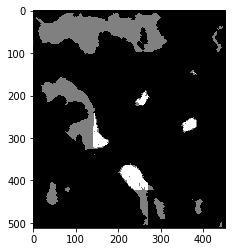

In [35]:
h2, w2 = imMaldi.shape # initial maldi dimentions
confocal_outline2 = 1-np.array(confocal_outline)/255
confocal_outline2, maldi_outline, maldi_denominator, common_denominator = matchshape(confocal_outline2,maldi_outline)
h3, w3 = confocal_outline2.shape #common dimentions
added_image = cv2.addWeighted(maldi_outline,1,confocal_outline2,1,0)
mn = sys.maxsize
iterations = 50 # increase for a better alignment, decrease for a faster
flag = 0
########
mn = sys.maxsize
for i in range(iterations):
  scale = uniform(1,2.5)
  p_opt = fmin(error_fun2, [uniform(-0.1, 0.1),uniform(-100, 100),uniform(-100, 100),scale], args=(maldi_outline.astype(np.float64),confocal_outline2.astype(np.float64)),xtol = 1e-13,ftol = 1e-13,disp = 0)
  fopt = error_fun2(p_opt,maldi_outline.astype(np.float64),confocal_outline2.astype(np.float64))
  if fopt < mn:
    mn = fopt
    xopt = p_opt
  print("iteration "+str(i)+"/"+str(2*iterations))
for i in range(iterations):
  scale = uniform(1,2.5)
  p_opt = fmin(error_fun2, [uniform(-0.1, 0.1),uniform(-100, 100),uniform(-100, 100),scale], args=(confocal_outline2.astype(np.float64),maldi_outline.astype(np.float64)),xtol = 1e-13,ftol = 1e-13,disp = 0)
  fopt = error_fun2(p_opt,confocal_outline2.astype(np.float64),maldi_outline.astype(np.float64))
  if fopt < mn:
    mn = fopt
    xopt = p_opt
    flag = 1
  print("iteration "+str(iterations+i)+"/"+str(2*iterations))
if flag == 1:
  maldi = transform_image(maldi_outline,xopt[0],xopt[1],xopt[2],xopt[3])
  added_image = cv2.addWeighted(maldi,1,confocal_outline2,1,0)
  plt.imshow(added_image, cmap = 'gray')
  plt.show()
  print("Optimal parameters (transform maldi): rotation ",xopt[0],", X shift ",xopt[1],",Y shift ",xopt[2],", scale ",xopt[3]) 
else:
  print("Optimal parameters (transform confocal): rotation ",xopt[0],", X shift ",xopt[1],",Y shift ",xopt[2],", scale ",xopt[3]) 
  maldi = transform_image(maldi_outline,-xopt[0],-xopt[1]/xopt[3],-xopt[2]/xopt[3],1/xopt[3])
  added_image = cv2.addWeighted(maldi,1,confocal_outline2,1,0)
  plt.imshow(added_image, cmap = 'gray')
  plt.show()

If you already have your alignment parameters input them at the cell below and run it. Flag = 1 means your parameters are for a MALDI transformation, flag = 0 for a confocal image transformation

In [0]:
flag = 1
xopt = [0,0,0,1]

## Crop and save the aligned images

In [0]:
# file locations
maldi_folder_path = "/content/drive/My Drive/confocal for segmentation/maldi folder"
confocal_folder_path = "/content/drive/My Drive/confocal for segmentation/confocal"
maldi_output_path = "/content/drive/My Drive/confocal for segmentation/maldi aligned"
crop_confocal_path = "/content/drive/My Drive/confocal for segmentation/cropped_confocal"
#####################################################################################
if not os.path.exists(maldi_output_path):os.mkdir(maldi_output_path)
l = os.listdir(maldi_folder_path)
l2 = os.listdir(confocal_folder_path)
if not os.path.exists(crop_confocal_path):os.mkdir(crop_confocal_path)

w_conf = int(w/common_denominator)
w_maldi = int(w2*maldi_denominator/common_denominator) 

if flag == 0: # means confocal was scaled up, image1 = confocal
  if w3 > w_conf: # image2 (maldi) is wider, image1 has a black gap on the right
    image2_outlines = np.ones((h3,w3))
    image2_outlines_transformed = transform_image(image2_outlines,-1*xopt[0],-1*xopt[1]/xopt[3],-1*xopt[2]/xopt[3],1/xopt[3]) # here all the xopt were done for confocal, xopt[3]>1, but here we scale maldi down, so we reverse xopt
    _, [top,bottom,left,right] = cut_background(image2_outlines_transformed)
    if right > w_conf:
      right = w_conf # confocal and maldi are going to be cropped right with [top:bottom,left:right] 
  elif w3 == w_conf: # image1 (confocal) is wider, image2 has a black gap on the right
    image2_outlines = np.concatenate((np.ones((h3,w_maldi)),np.zeros((h3,w3-w_maldi))), axis=1)
    image2_outlines_transformed = transform_image(image2_outlines,-1*xopt[0],-1*xopt[1]/xopt[3],-1*xopt[2]/xopt[3],1/xopt[3]) 
    _, [top,bottom,left,right] = cut_background(image2_outlines_transformed)
  for name in l2:
    confocal = cv2.imread(confocal_folder_path+"/"+name)
    cropped_confocal = np.array(confocal)[int(common_denominator*top):int(bottom*common_denominator),int(common_denominator*left):int(right*common_denominator)]
    cv2.imwrite(crop_confocal_path+"/"+name,cropped_confocal)

  for name in l: # make sure you have only maldi images of the same run in the folder, no technical files like ".Thumbs" etc
    im = cv2.imread(maldi_folder_path+"/"+name, cv2.IMREAD_GRAYSCALE)
    _, im, _, _ = matchshape(confocal_outline2,im)
    im = transform_image(im,-1*xopt[0],-1*xopt[1]/xopt[3],-1*xopt[2]/xopt[3],1/xopt[3])
    im = im[top:bottom,left:right]
    im = cv2.resize(im, dsize=(cropped_confocal.shape[1],cropped_confocal.shape[0]), interpolation=cv2.INTER_CUBIC)     
    cv2.imwrite(maldi_output_path+"/"+name,im)
else: # means maldi was scaled up, image1 = maldi
  if w3 > w_maldi: # image2 (confocal) is wider, image1 has a black gap on the right
    image2_outlines = np.ones((h3,w3))
    image2_outlines_transformed = transform_image(image2_outlines,0,-1*xopt[1]/xopt[3],-1*xopt[2]/xopt[3],1/xopt[3]) # here all the xopt were done for maldi, xopt[3]>1, but we pretend we scaled confocal down, so we reverse xopt 
    _, [top,bottom,left,right] = cut_background(image2_outlines_transformed)
    if right > w_maldi:
      right = w_maldi
    gap = 0
  elif w3 == w_maldi: # image1 (maldi) is wider, image2 has a black gap on the right
    image2_outlines = np.concatenate((np.ones((h3,w_conf)),np.zeros((h3,w3-w_conf))), axis=1)
    image2_outlines_transformed = transform_image(image2_outlines,0,-1*xopt[1]/xopt[3],-1*xopt[2]/xopt[3],1/xopt[3]) 
    plt.imshow(image2_outlines_transformed)
    plt.show()
    im, [top,bottom,left,right] = cut_background(image2_outlines_transformed)
    gap = int((w3-w_conf)*common_denominator)
  for name in l2:
    confocal = cv2.imread(confocal_folder_path+"/"+name)  
    new_confocal = pad_zeros(np.array(confocal),xopt[3],gap = gap)
    new_confocal_transformed = transform_image(new_confocal,0,-common_denominator*xopt[1],-common_denominator*xopt[2],1)
    multiplier = new_confocal_transformed.shape[0]/image2_outlines_transformed.shape[0]
    cropped_confocal = new_confocal_transformed[int(top*multiplier):int(bottom*multiplier),int(left*multiplier):int(right*multiplier)] 
    cv2.imwrite(crop_confocal_path+"/"+name,cropped_confocal)

  for name in l: # make sure you have only maldi images of the same run in the folder, no technical files like ".Thumbs" etc
    im = cv2.imread(maldi_folder_path+"/"+name, cv2.IMREAD_GRAYSCALE)
    _, im, _, _ = matchshape(confocal_outline2,im)
    im = transform_image(im,xopt[0],0,0,1)
    im = im[top:bottom,left:right]
    im = cv2.resize(im, dsize=(cropped_confocal.shape[1],cropped_confocal.shape[0]), interpolation=cv2.INTER_CUBIC)     
    cv2.imwrite(maldi_output_path+"/"+name,im)
